In [191]:
from keras.models import Sequential
from keras.layers import Convolution2D, BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator 
from keras.optimizers import SGD
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
import PIL

import os

import numpy as np

import matplotlib.pyplot as plt

In [192]:
# Parameters
img_width = 101
img_height = 101
batch_size = 64
keras = tf.keras

IMG_SHAPE = (img_height, img_width, 3)

In [193]:
def plot_roc(labels, prediction_scores):
    fpr, tpr, _ = metrics.roc_curve(labels, prediction_scores, pos_label=1)
    auc = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = 'AUC = {:0.3f}'.format(auc)
   
    plt.plot([0,1],[0,1],'--', color='gray', label='Chance')
    plt.plot(fpr, tpr, label=legend_string)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()
    
def load_data(dir_data, dir_labels, training=True):
    ''' Load each of the image files into memory 

    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory

    When training=True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    for identifier in ids:
        fname     = dir_data + identifier.astype(str) + '.tif'
        image     = mpl.image.imread(fname)
        data.append(image)
    data = np.array(data) # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids
    
def cv_performance_assessment(X,y,k,clf):
    '''Cross validated performance assessment
    
    X   = training data
    y   = training labels
    k   = number of folds for cross validation
    clf = classifier to use
    
    Divide the training data into k folds of training and validation data. 
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are 
    aggregated and output
    '''
    # Establish the k folds
    prediction_scores = np.empty(y.shape[0],dtype='object')
    kf = StratifiedKFold(n_splits=k, shuffle=True)
    for train_index, val_index in kf.split(X, y):
        # Extract the training and validation data for this fold
        X_train, X_val   = X[train_index], X[val_index]
        y_train          = y[train_index]
        
        # Train the classifier
        X_train_features = X_train
        clf              = clf.fit(X_train_features,y_train)
        
        # Test the classifier on the validation data for this fold
        X_val_features   = X_val
        cpred            = clf.predict_proba(X_val_features)
        
        # Save the predictions for this fold
        prediction_scores[val_index] = cpred[:,1]
    return prediction_scores

In [194]:

'''
Set directory parameters
'''
# Set the directories for the data and the CSV files that contain ids/labels
dir_train_images  = './data/training/'
dir_test_images   = './data/testing/'
dir_train_labels  = './data/labels_training.csv'
dir_test_ids      = './data/sample_submission.csv'
train_datagen = ImageDataGenerator(rescale = 1./255, vertical_flip = True, 
                                   horizontal_flip=True, channel_shift_range=50.0,
                                   rotation_range = 30, shear_range = 10.0,
                                   validation_split = 0.15)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [195]:
# Generate image label dataframe
# Dont run this
traindf = pd.read_csv("./data/labels_training.csv",dtype=str)
def append_ext(fn):
    return fn+".tif"
traindf["id"]=traindf["id"].apply(append_ext)
traindf = traindf.sample(frac=1)

train_generator = train_datagen.flow_from_dataframe( 
    dataframe=traindf,
    directory=train_data_dir, 
    x_col="id",
    y_col="label",
    seed=0,
    batch_size = batch_size,
    target_size=(img_height, img_width),
    shuffle=True,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_dataframe( 
    dataframe=traindf,
    directory=train_data_dir, 
    x_col="id",
    y_col="label",
    seed=0,
    target_size=(img_height, img_width),
    class_mode='binary',
    subset='validation',
    shuffle = False,
    batch_size = 225)

Found 1275 validated image filenames belonging to 2 classes.
Found 225 validated image filenames belonging to 2 classes.


## Try extracting features to do SVM ##

In [46]:
training_features = []
for i in range(1500):
    training_features.append(np.array(base_model(train_generator.next())).ravel())

In [47]:
np.savetxt("training_features_InceptionV3.csv", training_features, delimiter=",")

In [55]:
from sklearn import svm
from sklearn.metrics import classification_report
labels = train_generator.classes
clf = svm.SVC(kernel='rbf', degree = 3, probability=True, C=0.1, gamma='scale')
clf.fit(training_features, labels)

# Primary evaluation
score = clf.predict_proba(training_features)
auc = metrics.roc_auc_score(labels, score[:,1])
print(auc)
print (classification_report(labels, score[:,1]>0.5))

0.970727896910294
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       995
           1       0.91      0.81      0.86       505

    accuracy                           0.91      1500
   macro avg       0.91      0.89      0.90      1500
weighted avg       0.91      0.91      0.91      1500



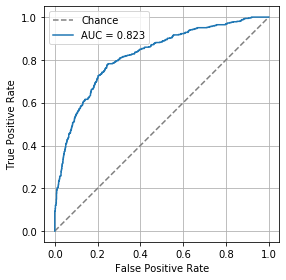

In [99]:
clf = svm.SVC(kernel='rbf', probability=True, C=1, gamma = 'scale')
# Perform cross validated performance assessment
prediction_scores = cv_performance_assessment(np.array(training_features),np.array(labels),5,clf)

# Compute and plot the ROC curves
plot_roc(labels, prediction_scores)

In [93]:
test_generator = test_datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=(img_width, img_height),
    color_mode="rgb",
    class_mode=None,
    shuffle=False,
    seed=42,
    batch_size=1
)
testing_features = []
for i in range(558):
    testing_features.append(np.array(base_model(test_generator.next())).ravel())


Found 558 images belonging to 1 classes.


In [100]:
clf = svm.SVC(kernel='rbf', probability=True, C=1, gamma = 'scale')
clf.fit(training_features, labels)

score = clf.predict_proba(testing_features)
dir_test_ids      = './data/sample_submission.csv'
dir_test_images   = './data/testing/'
test_data, ids = load_data(dir_test_images, dir_test_ids, training=False)
# Save the predictions to a CSV file for upload to Kaggle
submission_file = pd.DataFrame({'id':    ids,
                                   'score':  score[:,1]})
submission_file.to_csv('Inception_SVM2.csv',
                           columns=['id','score'],
                           index=False)

## Transfer learning ##

In [196]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
import keras
from keras.callbacks import CSVLogger

In [197]:
def CNN_mod(lr, weight, name, epoch = 100):
    # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # add a logistic layer -- let's say we have 200 classes
    predictions = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(x)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False
    #for layer in base_model.layers[1:4]:
    #    layer.trainable = True
    
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999), 
                  loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    
    filename = 'D:\\MIDS\\RedTeam\\' +name+ '.csv'
    csv_logger = CSVLogger(filename, append=True, separator=';')
    
    model.fit_generator(train_generator, validation_data=validation_generator ,
                        epochs=epoch, class_weight=weight, callbacks=[csv_logger])
    
    score = model.predict(train_generator)
    labels = train_generator.classes
    auc = metrics.roc_auc_score(labels, score.ravel())
    return (model, score, labels, auc)

In [198]:
def CNN_mod2(lr, weight, name, epoch = 100):
    # create the base pre-trained model
    
    model = Sequential()
    # First layer
    model.add(Convolution2D(filters = 8, kernel_size = (6, 6), strides = 1, 
                            input_shape = IMG_SHAPE, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (3, 3)))

    # Second layer
    model.add(Convolution2D(12, kernel_size = (6, 6), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (3, 3)))
    
    # Second layer
    model.add(Convolution2D(16, kernel_size = (4, 4), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (3, 3)))
    
    # Flatten
    model.add(Flatten())
    
    # FC
    model.add(Dense(units = 16, activation = 'sigmoid'))
    
    # Output 
    model.add(Dense(units = 1, activation = 'sigmoid'))
    
    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999), 
                  loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    
    filename = 'D:\\MIDS\\RedTeam\\' +name+ '.csv'
    csv_logger = CSVLogger(filename, append=True, separator=';')
    
    model.fit_generator(train_generator, validation_data=validation_generator ,
                        epochs=epoch, class_weight=weight, callbacks=[csv_logger])
    
    score = model.predict(train_generator)
    labels = train_generator.classes
    auc = metrics.roc_auc_score(labels, score.ravel())
    return (model, score, labels, auc)

In [204]:
model, s, l, a = CNN_mod2(0.005, {0:1., 1:1.2}, name = 'Try_to_overfit2', epoch = 60)

Epoch 1/60
20/20 [==============================] - 16s 808ms/step - loss: 0.7115 - auc_13: 0.5405 - val_loss: 0.6551 - val_auc_13: 0.5576
Epoch 2/60
20/20 [==============================] - 14s 688ms/step - loss: 0.6370 - auc_13: 0.6040 - val_loss: 0.6484 - val_auc_13: 0.6324
Epoch 3/60
20/20 [==============================] - 14s 698ms/step - loss: 0.6135 - auc_13: 0.6510 - val_loss: 0.7147 - val_auc_13: 0.6630
Epoch 4/60
20/20 [==============================] - 14s 696ms/step - loss: 0.6069 - auc_13: 0.6768 - val_loss: 0.6610 - val_auc_13: 0.6781
Epoch 5/60
20/20 [==============================] - 14s 698ms/step - loss: 0.5725 - auc_13: 0.6890 - val_loss: 0.8273 - val_auc_13: 0.6886
Epoch 6/60
20/20 [==============================] - 14s 698ms/step - loss: 0.5258 - auc_13: 0.7034 - val_loss: 0.8598 - val_auc_13: 0.7038
Epoch 7/60
20/20 [==============================] - 14s 697ms/step - loss: 0.5524 - auc_13: 0.7107 - val_loss: 0.8674 - val_auc_13: 0.7093
Epoch 8/60
20/20 [=========

20/20 [==============================] - 14s 699ms/step - loss: 0.3012 - auc_13: 0.8577 - val_loss: 0.8795 - val_auc_13: 0.8580
Epoch 60/60
20/20 [==============================] - 14s 700ms/step - loss: 0.3105 - auc_13: 0.8587 - val_loss: 0.4274 - val_auc_13: 0.8595


In [206]:
model.fit_generator(train_generator, validation_data=validation_generator ,
                        epochs=10, class_weight={0:1., 1:1.25})

from sklearn.metrics import classification_report

score = model.predict(validation_generator)
labels = validation_generator.classes
#plot_roc(labels, score.ravel())
auc = metrics.roc_auc_score(labels, score.ravel())
print(auc)
print (classification_report(labels, score.ravel()>=0.5))

Epoch 1/10
20/20 [==============================] - 15s 738ms/step - loss: 0.2979 - auc_13: 0.8756 - val_loss: 0.4050 - val_auc_13: 0.8761
Epoch 2/10
20/20 [==============================] - 15s 727ms/step - loss: 0.2373 - auc_13: 0.8769 - val_loss: 0.3057 - val_auc_13: 0.8777
Epoch 3/10
20/20 [==============================] - 15s 726ms/step - loss: 0.2282 - auc_13: 0.8785 - val_loss: 0.5763 - val_auc_13: 0.8790
Epoch 4/10
20/20 [==============================] - 14s 725ms/step - loss: 0.2447 - auc_13: 0.8797 - val_loss: 0.3381 - val_auc_13: 0.8804
Epoch 5/10
20/20 [==============================] - 15s 726ms/step - loss: 0.2290 - auc_13: 0.8811 - val_loss: 0.4294 - val_auc_13: 0.8818
Epoch 6/10
20/20 [==============================] - 15s 732ms/step - loss: 0.2267 - auc_13: 0.8824 - val_loss: 0.3841 - val_auc_13: 0.8832
Epoch 7/10
20/20 [==============================] - 14s 725ms/step - loss: 0.3028 - auc_13: 0.8837 - val_loss: 1.7441 - val_auc_13: 0.8832
Epoch 8/10
20/20 [=========

In [56]:
#callbackobj = tf.compat.v1.keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0,  
#          write_graph=True, write_images=True, write_grads = True, update_freq = 1)

In [17]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
   print(i, layer.name)


0 input_2
1 conv2d_95
2 batch_normalization_95
3 activation_95
4 conv2d_96
5 batch_normalization_96
6 activation_96
7 conv2d_97
8 batch_normalization_97
9 activation_97
10 max_pooling2d_5
11 conv2d_98
12 batch_normalization_98
13 activation_98
14 conv2d_99
15 batch_normalization_99
16 activation_99
17 max_pooling2d_6
18 conv2d_103
19 batch_normalization_103
20 activation_103
21 conv2d_101
22 conv2d_104
23 batch_normalization_101
24 batch_normalization_104
25 activation_101
26 activation_104
27 average_pooling2d_10
28 conv2d_100
29 conv2d_102
30 conv2d_105
31 conv2d_106
32 batch_normalization_100
33 batch_normalization_102
34 batch_normalization_105
35 batch_normalization_106
36 activation_100
37 activation_102
38 activation_105
39 activation_106
40 mixed0
41 conv2d_110
42 batch_normalization_110
43 activation_110
44 conv2d_108
45 conv2d_111
46 batch_normalization_108
47 batch_normalization_111
48 activation_108
49 activation_111
50 average_pooling2d_11
51 conv2d_107
52 conv2d_109
53 co

In [16]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

In [187]:
#score = model.predict_generator(validation_generator)
#labels = validation_generator.classes
from sklearn.metrics import classification_report

score = model.predict(validation_generator)
labels = validation_generator.classes
#plot_roc(labels, score.ravel())
auc = metrics.roc_auc_score(labels, score.ravel())
print(auc)
print (classification_report(labels, score.ravel()>=0.5))

0.9453009676890274
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       134
           1       0.82      0.89      0.85        91

    accuracy                           0.88       225
   macro avg       0.87      0.88      0.87       225
weighted avg       0.88      0.88      0.88       225



In [188]:
# Load the test data and test the classifier
test_data, ids = load_data(dir_test_images, dir_test_ids, training=False)
test_data = test_data/255
test_scores    = model.predict_proba(test_data)

# Save the predictions to a CSV file for upload to Kaggle
submission_file = pd.DataFrame({'id':    ids,
                                   'score':  test_scores.ravel()})
submission_file.to_csv('CNN_vanilla_0945.csv',
                           columns=['id','score'],
                           index=False)

In [184]:
peer = pd.read_csv('submission_PCA_SVM_3C.csv')
peer = pd.read_csv('Inception_SVM.csv')
#peer = pd.read_csv('CNN_vanilla3.csv')
np.corrcoef(test_scores.ravel(),np.array(peer.score))

array([[1.       , 0.5650166],
       [0.5650166, 1.       ]])

In [78]:
score.shape

(225, 1)

In [166]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_487 (Conv2D)          (None, 96, 96, 8)         872       
_________________________________________________________________
batch_normalization_485 (Bat (None, 96, 96, 8)         32        
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_488 (Conv2D)          (None, 27, 27, 12)        3468      
_________________________________________________________________
batch_normalization_486 (Bat (None, 27, 27, 12)        48        
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 9, 9, 12)          0         
_________________________________________________________________
conv2d_489 (Conv2D)          (None, 6, 6, 16)         